# Exploring Frederike's code

In [1]:
import networkx as nx
import random
import ba_utils.visualization as visualization
import ba_utils.orderings as orderings
import ba_utils.network_rugs as nrugs
import ba_utils.data_generator as dg

In [2]:
def generate_dynamic_graphs(
    num_nodes=30,
    num_steps=10,
    num_groups=1,
    change_rate=0,
    intra_community_strength=1.0,
    inter_community_strength=0.1,
    seed=42
):
    """
    Generate dynamic graphs with evolving group structures and guaranteed connectedness.

    Parameters:
        num_nodes (int): Total number of nodes.
        num_steps (int): Number of time steps (snapshots).
        num_groups (int): Number of initial communities.
        change_rate (float): Fraction of nodes changing group per step.
        intra_community_strength (float): Probability of edge within a community (0 to 1).
        inter_community_strength (float): Probability of edge between communities (0 to 1).
        seed (int): Random seed for reproducibility.

    Returns:
        graphs (dict): timestep → nx.Graph
        ground_truth (dict): timestep → {node: group}
        change_log (dict): timestep → list of changed node IDs
    """
    random.seed(seed)
    nodes = list(range(num_nodes))
    community_assignment = {node: node % num_groups for node in nodes}

    graphs = {}
    ground_truth = {}
    change_log = {}

    for t in range(num_steps):
        G = nx.Graph()
        G.add_nodes_from(nodes)

        # Add intra- and inter-community edges
        for i in range(num_nodes):
            for j in range(i+1, num_nodes):
                same_group = community_assignment[i] == community_assignment[j]
                p = intra_community_strength if same_group else inter_community_strength
                if random.random() < p:
                    G.add_edge(i, j, weight=1.0 if same_group else 0.3)

        # Force minimal connectivity between communities
        community_nodes = {g: [] for g in range(num_groups)}
        for node, group in community_assignment.items():
            community_nodes[group].append(node)

        sorted_communities = sorted(community_nodes.keys())
        for i in range(len(sorted_communities) - 1):
            node_a = random.choice(community_nodes[sorted_communities[i]])
            node_b = random.choice(community_nodes[sorted_communities[i + 1]])
            G.add_edge(node_a, node_b, weight=0.01)  # Very weak connecting edge

        # Store current graph and group structure
        graphs[t] = G
        ground_truth[t] = community_assignment.copy()

        # Track community changes (from previous timestep)
        if t > 0:
            prev_assignment = ground_truth[t-1]
            changed_nodes = [
                node for node in nodes
                if community_assignment[node] != prev_assignment[node]
            ]
            change_log[t] = changed_nodes

        # Evolve group membership
        num_changes = int(change_rate * num_nodes)
        for _ in range(num_changes):
            node = random.choice(nodes)
            current_group = community_assignment[node]
            new_group = random.choice([g for g in range(num_groups) if g != current_group])
            community_assignment[node] = new_group

    return graphs, ground_truth, change_log

In [3]:
simple, gt, cl = generate_dynamic_graphs(num_nodes=25, num_steps=50, num_groups=2)



Global stats: ((0.01, 1.0), (11, 18), (0, 14))
num_artists 25


(None,)

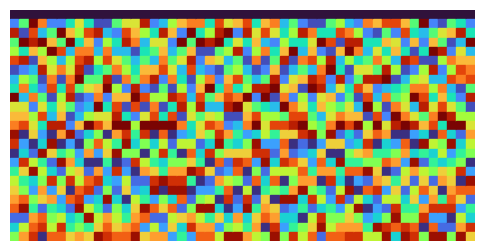

In [4]:
nrugs.draw_networkrug(simple, color_encoding="id3", pixel_size=12),


<module 'matplotlib.pyplot' from 'c:\\Users\\miric\\Documents\\GitHub\\NetworkRugs\\venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

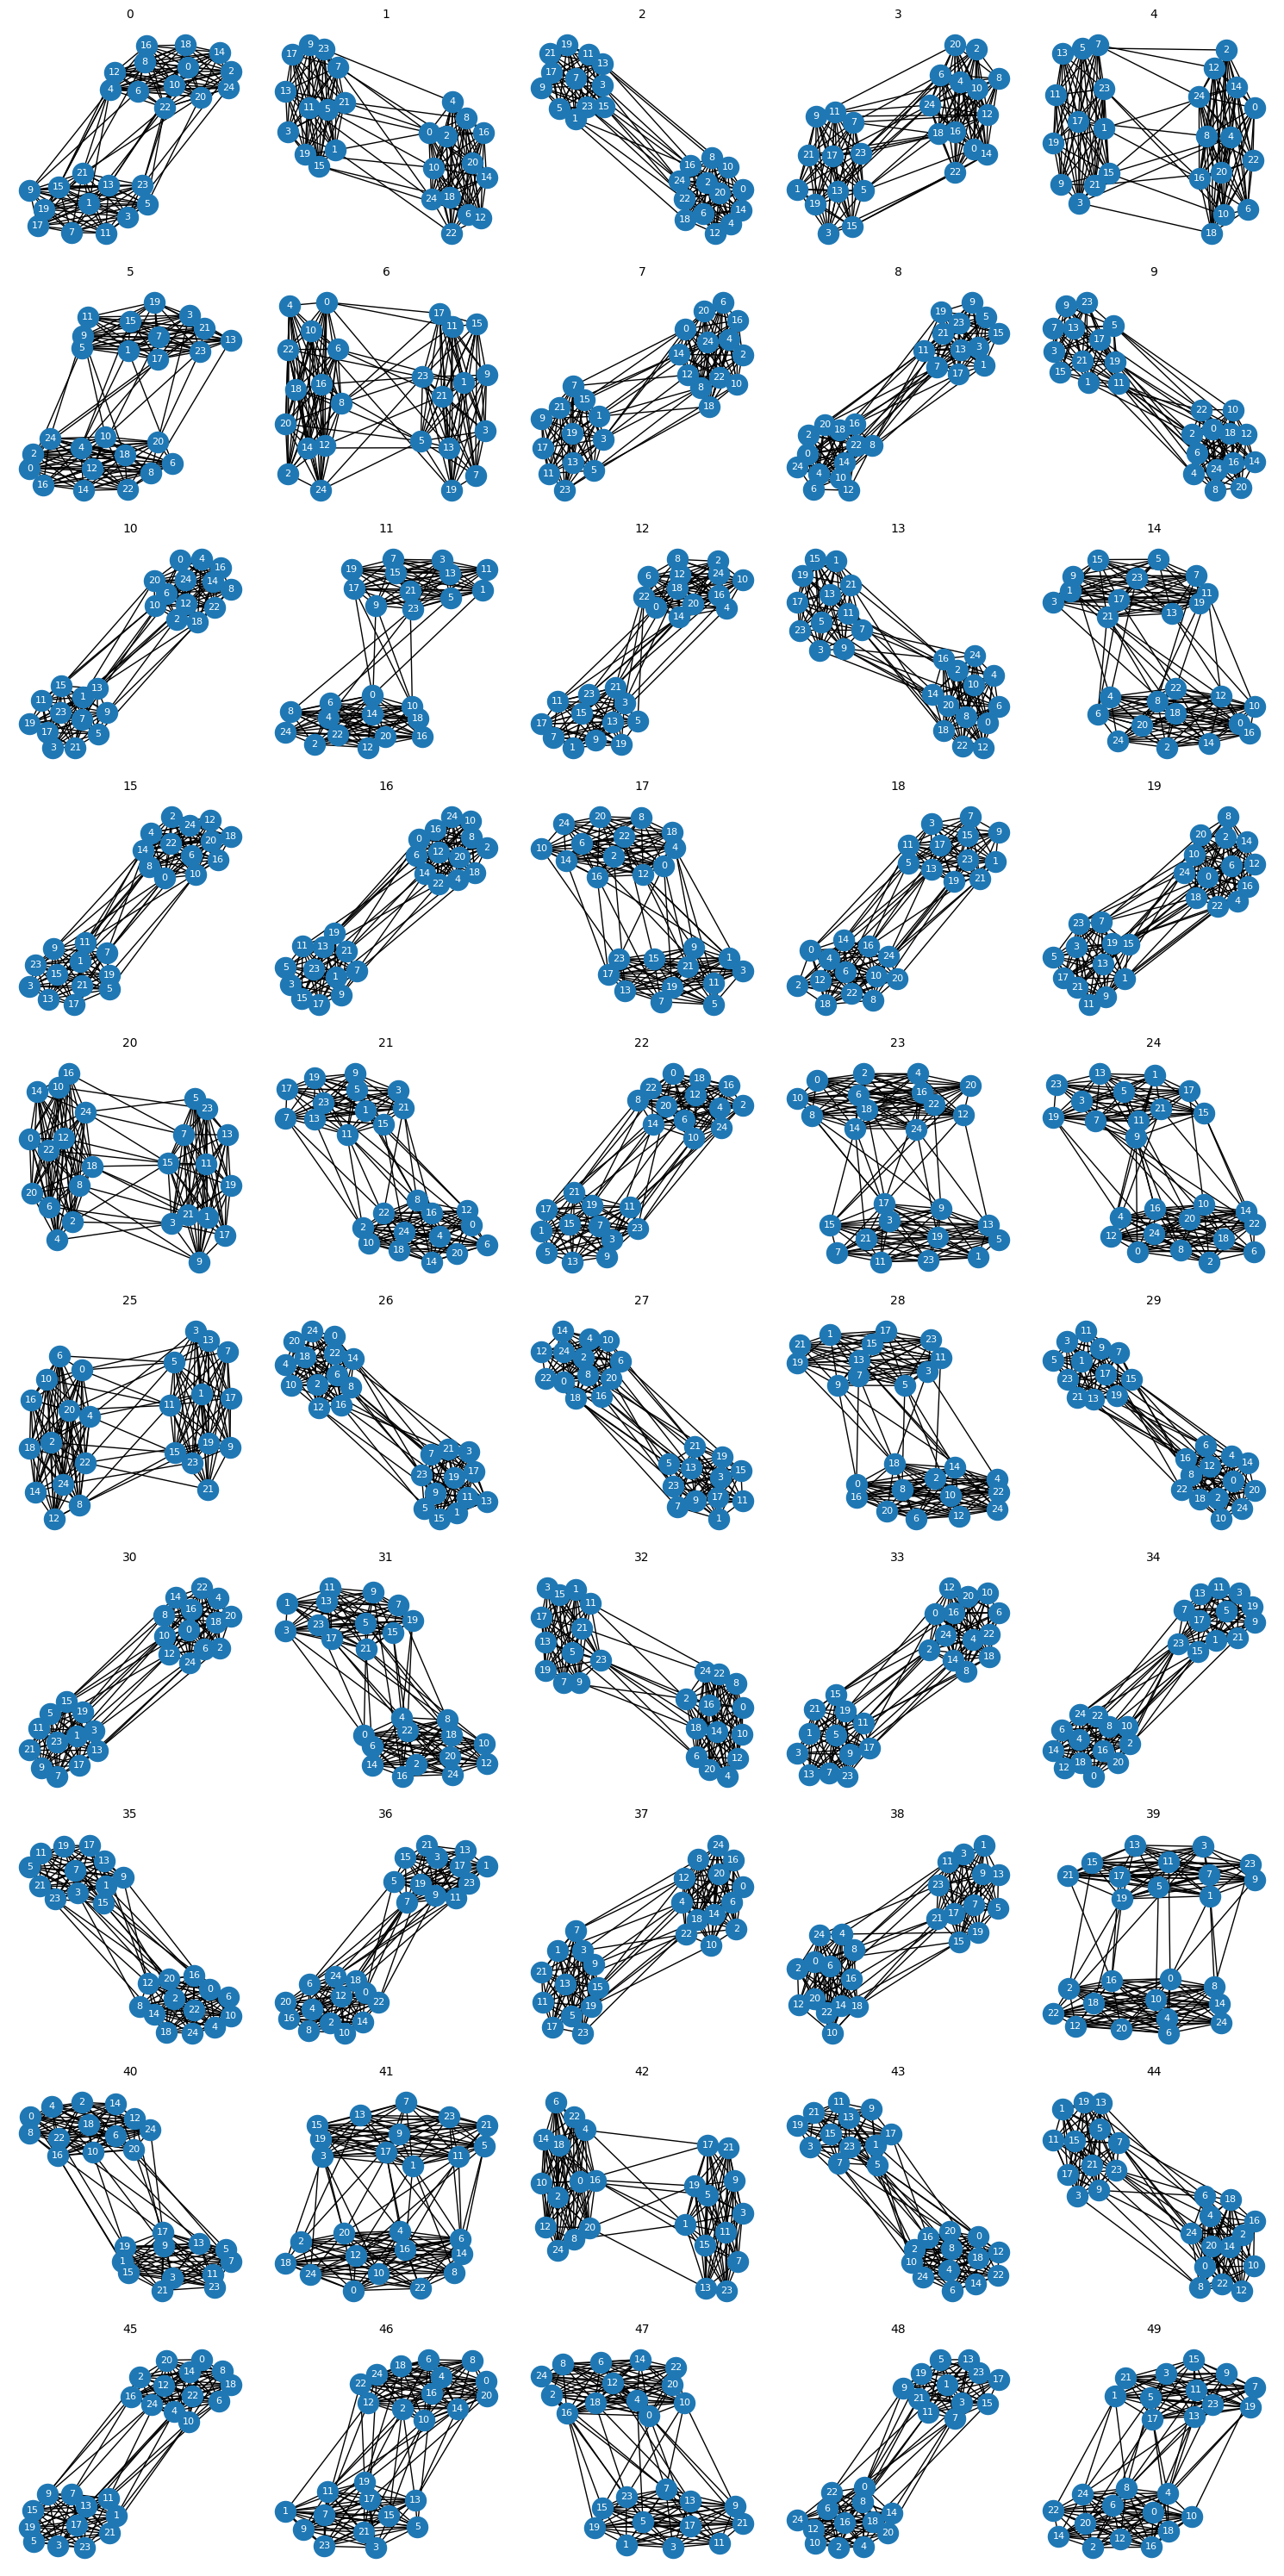

In [6]:
visualization.visualize_graphs(simple)


In [ ]:
fig = visualization.draw_all_colored(simple, title="Generated Graphs2", save=False, color_encoding="closeness_centrality", labels=False)
print(gt)

#if change_rate > 0:
#    print("Change log:")
#for t in cl:
#    print(f"Step {t}: {len(cl[t])} nodes changed — {cl[t]}")